In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, metrics
from sklearn import model_selection
from sklearn import linear_model
from sklearn import ensemble
from sklearn import svm
from collections import Counter
import copy
%matplotlib inline

### Fondamental data

In [2]:
data = pd.read_csv("data_sp500.csv", sep="|")

In [3]:
data = data.drop('Unnamed: 0', axis = 1)

In [4]:
features = list(data.columns)

In [5]:
companies = data["Nom de l'entreprise"].values.tolist()

### Historical prices

In [6]:
prices = pd.read_excel('historical_2018.xlsx')
prices.head()

,nom_entreprise,open_jan_2018,close_jan_2018,open_fev_2018,close_fev_2018,open_mar_2018,close_mar_2018,open_avr_2018,close_avr_2018
0,MMM,235.78,250.50,247.440,235.51,236.15,219.52,218.05,194.39
1,AOS,61.45,66.78,66.990,64.19,64.19,63.59,63.45,61.35
2,ABT,58.20,62.16,61.750,60.33,60.16,59.92,59.82,58.13
3,ABBV,97.14,112.22,112.240,115.83,115.91,94.65,94.00,96.55
4,ACN,153.50,160.70,160.155,161.01,161.28,153.50,151.82,151.20


## Deleting the empty data cells

In [7]:
def delete_nan(data_all, feature_names, company_names):
    matrix = data_all.drop("Nom de l'entreprise", axis=1).values
    n_modification = 1
    
    while n_modification > 0:
        n_modification = 0
        n,m = matrix.shape
        line_coef = 0
        line = 0
        col_coef = 0
        col = 0

        #Recherche du plus grand coefficient de données manquantes
        for i in range(n):
            new_coef = np.count_nonzero(np.isnan(matrix[i]))/len(matrix[i])
            if new_coef > line_coef:
                line_coef = new_coef
                line = i
                n_modification += 1
        for j in range(m):
            new_coef = np.count_nonzero(np.isnan(matrix[:,j]))/len(matrix[:,j])
            if new_coef > col_coef:
                col_coef = new_coef
                col = j
                n_modification += 1

        matrix = matrix.tolist()
        if (n_modification > 0) and (line_coef < col_coef):
            del feature_names[col]
            for row in matrix:
                del row[col]
        elif (n_modification > 0) and (col_coef <= line_coef):
            del company_names[line]
            del matrix[line]
        
        matrix = np.array(matrix)
            
    #Re-adding the company names
    matrix = matrix.tolist()
    for i in range(len(matrix)):
        matrix[i] = [company_names[i]] + matrix[i]
    
    new_data = pd.DataFrame(matrix)
    new_data.columns = feature_names
    
    return new_data, feature_names, company_names    

In [8]:
data, features, companies = delete_nan(data, features, companies)

In [120]:
features

["Nom de l'entreprise",
 'P/E Ratio (TTM) (Company)',
 'P/E High - Last 5 Yrs. (Company)',
 'P/E Low - Last 5 Yrs. (Company)',
 'Beta (Company)',
 'Price to Sales (TTM) (Company)',
 'Price to Tangible Book (MRQ) (Company)',
 'Dividend 5 Year Growth Rate (Company)',
 'Payout Ratio(TTM) (Company)',
 'Sales (MRQ) vs Qtr. 1 Yr. Ago (Company)',
 'Sales (TTM) vs TTM 1 Yr. Ago (Company)',
 'Sales - 5 Yr. Growth Rate (Company)',
 'EPS (MRQ) vs Qtr. 1 Yr. Ago (Company)',
 'EPS - 5 Yr. Growth Rate (Company)',
 'Current Ratio (MRQ) (Company)',
 'LT Debt to Equity (MRQ) (Company)',
 'Gross Margin - 5 Yr. Avg. (Company)',
 'EBITD Margin (TTM) (Company)',
 'EBITD - 5 Yr. Avg (Company)',
 'Operating Margin (TTM) (Company)',
 'Operating Margin - 5 Yr. Avg. (Company)',
 'Pre-Tax Margin (TTM) (Company)',
 'Pre-Tax Margin - 5 Yr. Avg. (Company)',
 'Net Profit Margin (TTM) (Company)',
 'Net Profit Margin - 5 Yr. Avg. (Company)',
 'Effective Tax Rate - 5 Yr. Avg. (Company)',
 'Revenue/Employee (TTM) (Compa

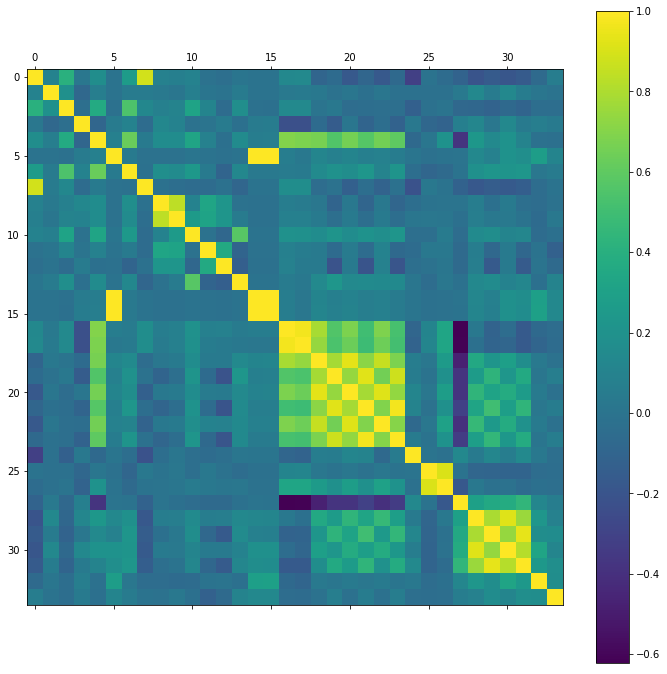

In [70]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
cax = ax.matshow((data.drop("Nom de l'entreprise", axis=1)).corr())
fig.colorbar(cax)
plt.savefig('correlation.png', dpi=300)
plt.show()

In [10]:
np.corrcoef(data[features[16]],data[features[15]])

array([[ 1.        ,  0.99936147],
       [ 0.99936147,  1.        ]])

In [68]:
features[16], features[15]

('Gross Margin - 5 Yr. Avg. (Company)', 'LT Debt to Equity (MRQ) (Company)')

#### Equivalent on the prices

In [12]:
prices_features = prices.columns
prices_lists = prices.values.tolist()

In [13]:
i = 0

for compteur in range(len(prices_lists)):
    if prices_lists[i][0] not in companies:
        del prices_lists[i]
        i = i-1
    i += 1    
    

prices = pd.DataFrame(prices_lists)
prices.columns = prices_features

## Labelling the companies
Good = 1
Bad = 0

The frequency here is over a year so we can have all the specific information on the companies up to date

"Good" companies are those who have an increase of at least 10% since the opening one the period time.

"Bad" ones are the others

In [14]:
prices_values = prices.drop('nom_entreprise', axis=1).values
print (prices_values)

[[ 235.78  250.5   247.44 ...,  219.52  218.05  194.39]
 [  61.45   66.78   66.99 ...,   63.59   63.45   61.35]
 [  58.2    62.16   61.75 ...,   59.92   59.82   58.13]
 ..., 
 [  68.21   72.26   72.5  ...,   76.92   76.92   72.9 ]
 [ 121.    127.12  126.35 ...,  109.04  108.89  115.17]
 [  72.54   76.73   76.84 ...,   83.51   83.17   83.48]]


### January

In [15]:
#Labels for January 2018
labels_jan = []
for i in range(len(data)):
    evol = (prices_values[i][1] - prices_values[i][0])/prices_values[i][0]
    if evol > 0.05:    #Evolution of at least 5%
        labels_jan.append(1)
    else:
        labels_jan.append(0)

In [16]:
labels_jan.count(1)

153

### February

In [17]:
#Labels for February 2018
labels_feb = []
for i in range(len(data)):
    evol = (prices_values[i][3] - prices_values[i][0])/prices_values[i][0]
    if evol > 0.05:    #Evolution of at least 5%
        labels_feb.append(1)
    else:
        labels_feb.append(0)

In [18]:
labels_feb.count(1)

89

### March

In [19]:
#Labels for March 2018
labels_mar = []
for i in range(len(data)):
    evol = (prices_values[i][5] - prices_values[i][0])/prices_values[i][0]
    if evol > 0.05:    #Evolution of at least 5%
        labels_mar.append(1)
    else:
        labels_mar.append(0)

In [20]:
labels_mar.count(1)

80

### April

In [21]:
#Labels for April 2018
labels_apr = []
for i in range(len(data)):
    evol = (prices_values[i][7] - prices_values[i][0])/prices_values[i][0]
    if evol > 0.05:    #Evolution of at least 5%
        labels_apr.append(1)
    else:
        labels_apr.append(0)

In [22]:
labels_apr.count(1)

94

### Data Preprocessing

In [93]:
X_tr, X_te, y_tr, y_te = model_selection.train_test_split(data, labels_jan, test_size = 0.2, shuffle=True)

In [94]:
X_tr = X_tr.drop("Nom de l'entreprise", axis=1).values
X_te = X_te.drop("Nom de l'entreprise", axis=1).values

In [95]:
from sklearn.preprocessing import StandardScaler

In [96]:
scaler = StandardScaler()

In [97]:
X_tr = scaler.fit_transform(X_tr)
X_te = scaler.transform(X_te)

In [98]:
y_tr = np.array(y_tr)
y_te = np.array(y_te)

# Plot

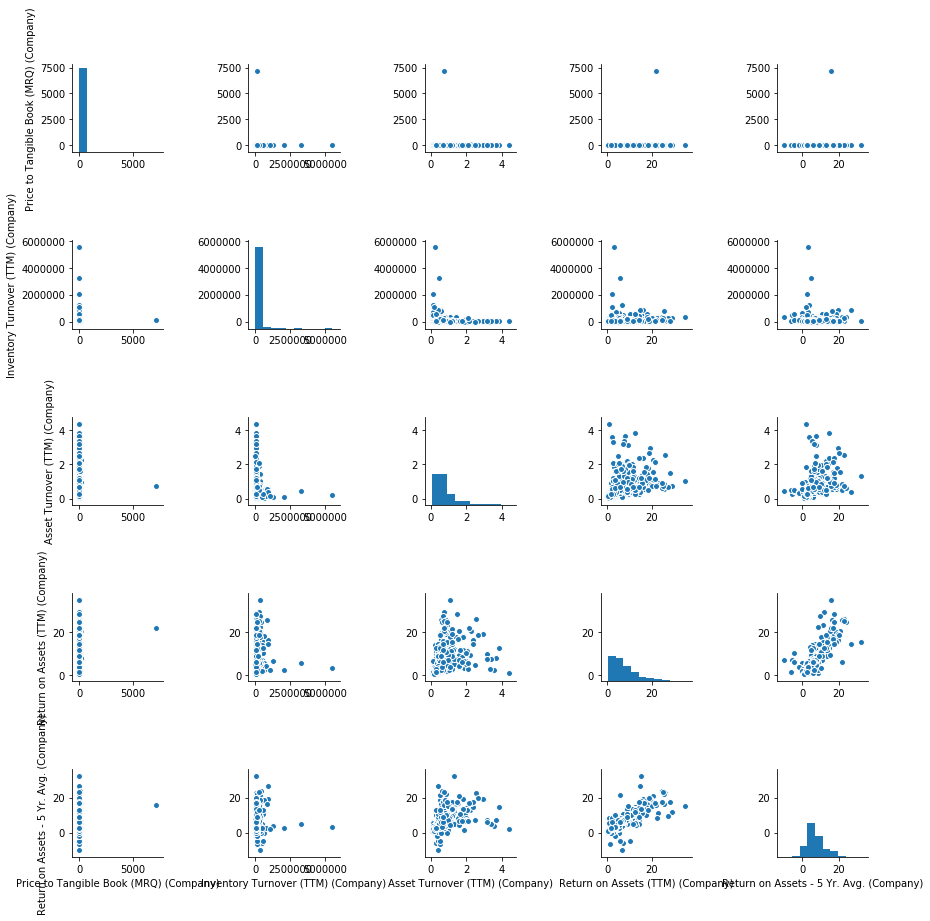

In [99]:
sns.pairplot(data[['Price to Tangible Book (MRQ) (Company)','Inventory Turnover (TTM) (Company)','Asset Turnover (TTM) (Company)','Return on Assets (TTM) (Company)','Return on Assets - 5 Yr. Avg. (Company)']])

# Models functions

In [100]:
def cross_validation(X, X_test, y, y_test, classifier, kf):
    train_accuracy = []
    test_accuracy = []
    test_auc = []
    pred_train_list = np.array([0 for _ in range(len(y))])
    pred_test_list = np.array([0 for _ in range(len(y))])
    test_prediction_list = []    #Global test predictions
    train_prediction_list = []
    
    print("|-> Cross-Validation")
    
    for train_index, test_index in kf.split(X):
        X_train_, X_test_ = X[train_index], X[test_index]
        y_train_, y_test_ = y[train_index], y[test_index]
        
        classifier.fit(X_train_, y_train_)
        
        pred_test = classifier.predict(X_test_)
        pred_train = classifier.predict(X_train_)
        test_prediction = classifier.predict(X_test)
        train_prediction = classifier.predict(X)
        
        pred_train_list[train_index] = pred_train
        pred_test_list[test_index] = pred_test
        test_prediction_list.append(test_prediction.tolist())
        train_prediction_list.append(train_prediction.tolist())
        
        test_accuracy.append(metrics.accuracy_score(y_test_, pred_test))
        train_accuracy.append(metrics.accuracy_score(y_train_, pred_train))
        test_auc.append(metrics.roc_auc_score(y_test_,pred_test))
        
        print("|--> Pass number {} : Accuracy = {}, AUC = {}".format(len(test_accuracy), test_accuracy[-1], test_auc))
        
    test_prediction_list = np.array(test_prediction_list).T
    final_test_prediction = [Counter(test_prediction_list[i]).most_common(1)[0][0] for i in range(len(test_prediction_list))]
    
    train_prediction_list = np.array(train_prediction_list).T
    final_train_prediction = [Counter(train_prediction_list[i]).most_common(1)[0][0] for i in range(len(train_prediction_list))]
    
    
    print("|-> Test data : Outter CV Accuracy = %0.3f, AUC = %0.3f, Precision = %0.3f, Recall = %0.3f" % (metrics.accuracy_score(y_test,final_test_prediction),  
                                                                                          metrics.roc_auc_score(y_test, final_test_prediction),
                                                                                         metrics.precision_score(y_test, final_test_prediction),
                                                                                                         metrics.recall_score(y_test, final_test_prediction)))
    print("|-> Train data : Outter CV Accuracy = %0.3f, AUC = %0.3f, Precision = %0.3f, Recall = %0.3f" % (metrics.accuracy_score(y,final_train_prediction),  
                                                                                            metrics.roc_auc_score(y, final_train_prediction),
                                                                                          metrics.precision_score(y, final_train_prediction),
                                                                                          metrics.recall_score(y,final_train_prediction)))
    
    scores = [test_accuracy, train_accuracy, test_auc]
    
    return pred_test_list, pred_train_list, final_test_prediction, final_train_prediction, scores

In [101]:
kf = model_selection.KFold(n_splits=7, shuffle=False)

### Logistic Regression

In [102]:
from sklearn.model_selection import GridSearchCV

In [117]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] 
             }

logistic = linear_model.LogisticRegression(penalty='l1')

grid_log = GridSearchCV(logistic, param_grid, cv = 7)

In [118]:
pred_test_list, pred_train_list, pred_test, pred_train, scores = cross_validation(X_tr, X_te, y_tr, y_te, grid_log, kf)

|-> Cross-Validation
|--> Pass number 1 : Accuracy = 0.6666666666666666, AUC = [0.66136363636363638]
|--> Pass number 2 : Accuracy = 0.7619047619047619, AUC = [0.66136363636363638, 0.76235294117647057]
|--> Pass number 3 : Accuracy = 0.6428571428571429, AUC = [0.66136363636363638, 0.76235294117647057, 0.63411764705882356]
|--> Pass number 4 : Accuracy = 0.5, AUC = [0.66136363636363638, 0.76235294117647057, 0.63411764705882356, 0.48798076923076916]
|--> Pass number 5 : Accuracy = 0.4878048780487805, AUC = [0.66136363636363638, 0.76235294117647057, 0.63411764705882356, 0.48798076923076916, 0.47101449275362323]
|--> Pass number 6 : Accuracy = 0.6585365853658537, AUC = [0.66136363636363638, 0.76235294117647057, 0.63411764705882356, 0.48798076923076916, 0.47101449275362323, 0.58974358974358976]
|--> Pass number 7 : Accuracy = 0.5853658536585366, AUC = [0.66136363636363638, 0.76235294117647057, 0.63411764705882356, 0.48798076923076916, 0.47101449275362323, 0.58974358974358976, 0.581339712918

In [119]:
grid_log.best_estimator_

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [88]:
pred = best_log.predict(X_te)
metrics.accuracy_score(y_te, pred), metrics.roc_auc_score(y_te, pred)

(0.72602739726027399, 0.54669811320754713)

### SVM

In [112]:
svc = svm.SVC()
param_grid_svm = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'kernel': ['linear', 'poly', 'sigmoid', 'rbf'],
              'degree' : [2,3]
             }
grid_svm = GridSearchCV(svc, param_grid_svm, cv = 7)
pred_test_list_svm, pred_train_list_svm, pred_test_svm, pred_train_svm, scores_svm = cross_validation(X_tr, X_te, y_tr, y_te, grid_svm, kf)

|-> Cross-Validation
|--> Pass number 1 : Accuracy = 0.6904761904761905, AUC = [0.6886363636363636]
|--> Pass number 2 : Accuracy = 0.6904761904761905, AUC = [0.6886363636363636, 0.66470588235294126]
|--> Pass number 3 : Accuracy = 0.6666666666666666, AUC = [0.6886363636363636, 0.66470588235294126, 0.64470588235294113]
|--> Pass number 4 : Accuracy = 0.47619047619047616, AUC = [0.6886363636363636, 0.66470588235294126, 0.64470588235294113, 0.45673076923076916]
|--> Pass number 5 : Accuracy = 0.4634146341463415, AUC = [0.6886363636363636, 0.66470588235294126, 0.64470588235294113, 0.45673076923076916, 0.44323671497584544]
|--> Pass number 6 : Accuracy = 0.6585365853658537, AUC = [0.6886363636363636, 0.66470588235294126, 0.64470588235294113, 0.45673076923076916, 0.44323671497584544, 0.61794871794871797]
|--> Pass number 7 : Accuracy = 0.6341463414634146, AUC = [0.6886363636363636, 0.66470588235294126, 0.64470588235294113, 0.45673076923076916, 0.44323671497584544, 0.61794871794871797, 0.630

In [113]:
grid_svm.best_estimator_

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Random Forest

In [114]:
rd_forest = ensemble.RandomForestClassifier()
param_grid_forest = {'n_estimators' : [11,12,15,17,18,20,25,30]
                 }
grid_forest = GridSearchCV(rd_forest, param_grid_forest, cv = 7)
pred_test_list_rdf, pred_train_list_rdf, pred_test_rdf, pred_train_rdf, scores_rdf = cross_validation(X_tr, X_te, y_tr, y_te, grid_forest, kf)

|-> Cross-Validation
|--> Pass number 1 : Accuracy = 0.5952380952380952, AUC = [0.59318181818181814]
|--> Pass number 2 : Accuracy = 0.6666666666666666, AUC = [0.59318181818181814, 0.63529411764705879]
|--> Pass number 3 : Accuracy = 0.6666666666666666, AUC = [0.59318181818181814, 0.63529411764705879, 0.63529411764705879]
|--> Pass number 4 : Accuracy = 0.7619047619047619, AUC = [0.59318181818181814, 0.63529411764705879, 0.63529411764705879, 0.73557692307692313]
|--> Pass number 5 : Accuracy = 0.5853658536585366, AUC = [0.59318181818181814, 0.63529411764705879, 0.63529411764705879, 0.73557692307692313, 0.56400966183574874]
|--> Pass number 6 : Accuracy = 0.8048780487804879, AUC = [0.59318181818181814, 0.63529411764705879, 0.63529411764705879, 0.73557692307692313, 0.56400966183574874, 0.74743589743589733]
|--> Pass number 7 : Accuracy = 0.4634146341463415, AUC = [0.59318181818181814, 0.63529411764705879, 0.63529411764705879, 0.73557692307692313, 0.56400966183574874, 0.74743589743589733,

In [115]:
grid_forest.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=17, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)